# 미니 프로젝트 : 가위바위보 분류기를 만들자

<ol>
<li>데이터 로드</li>
<li>이미지 전처리(리사이즈,픽셀별 정규화 ...)</li>
<li>모델 설계/빌드</li>
<li>모델 컴파일(하이퍼파라미터...설정)</li>
<li>모델 학습</li>
<li>모델 평가(정확도 ... )</li>
<li>예측 수행</li>
</ol>



## 프로젝트 목표와 계획

<ol>
<li>모델학습 결과를 시각화 한다. train acc/loss, val acc/loss</li>
<li>Overfiting 극복을 위한 DataSet의 다양성을 위해 Laurence Moroney의 rock-paper-scissors-dataset을 활용하며 전처리 정규화 과정을 진행한다.

    lms에서 가이드하고 있는 가위바위보 각각 100장의 이미지 데이터만으로는 학습결과/Test accuracy 결과가 10~최상50% 넘지 못하였다.
    그래서 데이터셋의 중요성을 인지하고 1500장의 데이터셋을 구하고 테스트 해 본 결과 88%의 결과를 이룰 수 있었다. 
    하지만 이 결과는 정확도 85% 달성은 이루었지만 범용성면에서 신뢰가 떨어질 수 있다 생각했다.(예: 세 손가락으로 만든 가위 등)
    그래서 좀 더 확장된 데이터셋을 찾았고 이것을 최종 프로젝트 데이터셋으로 활용하기로 했다.

    Introducing Rock Paper Scissors – A multi class learning dataset
    It has Creative Commons CC BY 2.0 Licence. Free use with declareation of the producer.
    http://www.laurencemoroney.com/rock-paper-scissors-dataset/
    Laurence Moroney (lmoroney@gmail.com / laurencemoroney.com)

    테스트 데이터셋은 lms 노드에서 제공하고 있는 테스트 데이트셋을 활용하기로 했다.
</li>
<li>test acc 85% 이상을 목표로 한다.</li>

</ol>


#### Q. 다운로드 받은 이미지는 크기는 무엇일까요? "nxn"(n은 정수)의 형태로 나타내 보세요.
224x224

### 라이브러리 버전 확인

In [37]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


print(tf.__version__)
print(np.__version__)

2.12.0
1.23.5


## 1. 데이터 로드 - 리사이즈,픽셀 정규화

In [39]:

from PIL import Image
import glob

def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")

	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		# new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img=old_img.resize(target_size,Image.LANCZOS) #Pillow 라이브러리 업데이트로 인한 문제를 예방
		new_img.save(img, "JPEG")
		# new_img=old_img.resize(target_size,Image.ANTIALIAS)
        #/var/folders/pr/61td1y8x20gbmv2fk3q0zlyc0000gn/T/ipykernel_85361/4242410451.py:13: 
        # DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). 
        # Use LANCZOS or Resampling.LANCZOS instead.
	print(len(images), " images resized.")

print("-----------------------------")
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/scissors"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")
print("-----------------------------")
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 사이즈를 변경합니다.
image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")
print("-----------------------------")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 사이즈를 변경합니다.
image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

-----------------------------
2564  images to be resized.
2564  images resized.
가위 이미지 resize 완료!
-----------------------------
2564  images to be resized.
2564  images resized.
보 이미지 resize 완료!
-----------------------------
2564  images to be resized.
2564  images resized.
바위 이미지 resize 완료!


## 2. 이미지 파일 load /  전처리 (x_train_norm = x_train/255.0)

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split # scikit-learn 패키지에는 데이터셋을 훈련 세트와 테스트 세트로 나누는 
                                                     #train_test_split이라는 함수가 있다. 이것을 이용해 훈련/테스트 셋을 나누자.

def load_data(img_path, number_of_data=7692):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper"
x_train, y_train =load_data(image_dir_path)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2025) #train_test_split 함수를 사용하여 훈련 데이터를 훈련 세트와 검증 세트로 나누고 있습니다. 
                                                                                                          #test_size=0.2는 전체 데이터 중 20%를 검증 세트로 사용하겠다는 것을 의미
                                                                                                          #random_state는 난수 생성에 사용되는 시드(seed) 값.
                                                                                                          #시드 값을 지정하면 난수 발생 시 초기 상태가 동일해지므로, 같은 시드 값을 사용하면 랜덤한 결과를 얻을 수 있다. 
                                                                                                          # 따라서 random_state=20231029은 20231029이라는 임의의 정수를 시드 값으로 사용한다는 의미이다.
                                                                                                          # 만약 같은 데이터셋과 같은 모델을 사용하여 실험을 재현하고 싶다면, 같은 시드 값을 사용하는 것이 좋다.
x_train_norm, x_val_norm = x_train/255.0, x_val /255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))


학습데이터(x_train)의 이미지 개수는 5128 입니다.
x_train shape: (6153, 28, 28, 3)
y_train shape: (6153,)


라벨 :  1


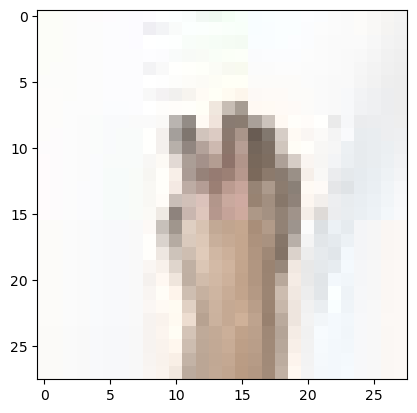

In [15]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨 : ', y_train[0])

## 3.4. 모델 빌드 - 딥러닝 네트워크 설계/컴파일

#### Q. 모델의 입력/출력부에 특히 유의하여 모델을 직접 만들어 보세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?

MNIST 데이터셋의 최종 분류 class 수는 10, 가위바위보 데이터셋의 최종 분류 class 수는 3

In [41]:
# tf.keras의 Sequential API를 이용하여 LeNet이라는 딥러닝 네트워크를 설계

import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요.
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (

## 5. 모델 학습

#### Q. model.compile()과 model.fit()을 사용

In [48]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# 입력이미지의 크기에 채널 추가
print(f"Before Reshape - x_train_norm shape: {x_train_norm.shape}")
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_reshaped, y_train, epochs=10, validation_data=(x_val_norm, y_val))
     

Before Reshape - x_train_norm shape: (6153, 28, 28, 3)
Epoch 1/10
193/193 [==============================] - 1s 5ms/step - loss: 0.2704 - accuracy: 0.8942 - val_loss: 0.1512 - val_accuracy: 0.9519
Epoch 2/10
193/193 [==============================] - 1s 5ms/step - loss: 0.0442 - accuracy: 0.9867 - val_loss: 0.0200 - val_accuracy: 0.9942
Epoch 3/10
193/193 [==============================] - 1s 5ms/step - loss: 0.0125 - accuracy: 0.9976 - val_loss: 0.0049 - val_accuracy: 0.9994
Epoch 4/10
193/193 [==============================] - 1s 5ms/step - loss: 0.0037 - accuracy: 0.9997 - val_loss: 0.0035 - val_accuracy: 0.9987
Epoch 5/10
193/193 [==============================] - 1s 5ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/10
193/193 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9994
Epoch 7/10
193/193 [==============================] - 1s 5ms/step - loss: 4.9230e-04 - accura

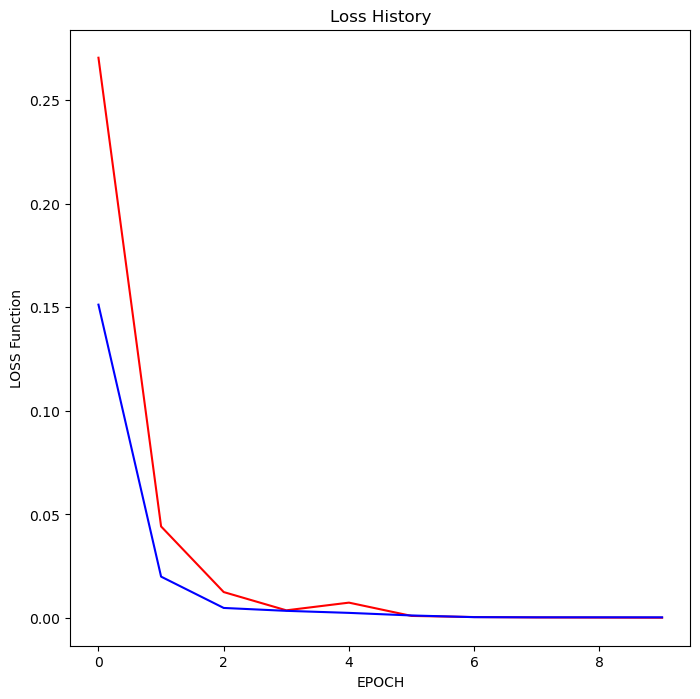

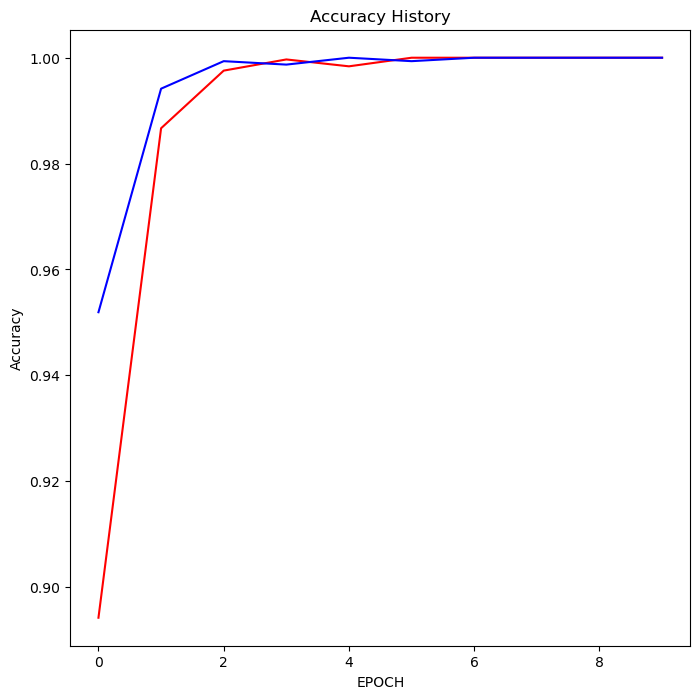

In [49]:

train_history = history.history["loss"]
validation_history = history.history["val_loss"]
fig = plt.figure(figsize=(8, 8))
plt.title("Loss History")
plt.xlabel("EPOCH")
plt.ylabel("LOSS Function")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
fig.savefig("train_history.png")
plt.show()

train_history = history.history["accuracy"]
validation_history = history.history["val_accuracy"]
fig = plt.figure(figsize=(8, 8))
plt.title("Accuracy History")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
fig.savefig("accuracy_history.png")
plt.show()

## 6. 테스트 데이터 

In [50]:
# x_test, y_test를 만드는 방법은 x_train, y_train을 만드는 방법과 아주 유사합니다.
# scissor
test_image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/test/scissors"
resize_images(test_image_dir_path)
print("test - 가위 이미지 resize 완료!")
print("-----------------------------")

# rock
test_image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/test/rock"
resize_images(test_image_dir_path)
print("test - 바위 이미지 resize 완료!")
print("-----------------------------")
# paper
test_image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/test/paper"
resize_images(test_image_dir_path)
print("test - 보 이미지 resize 완료!")
print("-----------------------------")
# 우선 테스트용 데이터인 x_test, y_test를 만들어 봅시다.
test_image_dir_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/test"
x_test, y_test = load_data(test_image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
test - 가위 이미지 resize 완료!
-----------------------------
100  images to be resized.
100  images resized.
test - 바위 이미지 resize 완료!
-----------------------------
100  images to be resized.
100  images resized.
test - 보 이미지 resize 완료!
-----------------------------
학습데이터(x_train)의 이미지 개수는 200 입니다.
x_test shape: (7692, 28, 28, 3)
y_test shape: (7692,)


### 테스트용 데이터 x_test, y_test

In [47]:

# 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수

import numpy as np
import matplotlib.pyplot as plt
img_path = "/Users/inho/study/github/aiffel/personal/AIFFEL_quest_iNho/main_quest/rock_scissor_paper/test"
def load_test_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("시험데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

(x_test, y_test)=load_test_data(test_image_dir_path)
x_test_norm = x_test/255.0   # 전처리 정규화: 입력은 0~1 사이의 값으로 정규화

print("-----------------------------")
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("-----------------------------")

print(f"Before Reshape - x_test_norm shape: {x_test_norm.shape}")
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산
print(f"After Reshape - x_test_reshaped shape: {x_test_reshaped.shape}")

print("-----------------------------")
print(x_train.shape)
print(x_test.shape)

# lms 다시 복기 ------------------
# 우리가 만든 네트워크의 입력은 (데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수) 와 같은 형태를 가집니다. 
# 이전 스텝에서 첫 번째 레이어에 input_shape=(28,28,1)로 지정했던 것을 기억하시나요?
# 그런데 print(x_train.shape) 을 해보면, (60000, 28, 28) 로 채널수에 대한 정보가 없습니다. 
# 따라서 (60000, 28, 28, 1) 로 만들어 주어야 합니다 (여기서 채널수 1은 흑백 이미지를 의미합니다. 
# 컬러 이미지라면 R, G, B 세 가지 값이 있기 때문에 3이겠죠?).

시험데이터(x_test)의 이미지 개수는 300 입니다.
-----------------------------
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
-----------------------------
Before Reshape - x_test_norm shape: (300, 28, 28, 3)
After Reshape - x_test_reshaped shape: (300, 28, 28, 3)
-----------------------------
(6153, 28, 28, 3)
(300, 28, 28, 3)


## Test Data 모델성능평가

## 모델 평가 : model.evaluate(x_test_reshaped,y_test, verbose=2)

In [51]:
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(x_test_norm ,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print("테스트 정확도: {:.4f}".format(test_accuracy))


241/241 - 0s - loss: 0.0410 - accuracy: 0.9878 - 362ms/epoch - 2ms/step
test_loss: 0.041009385138750076
테스트 정확도: 0.9878


241/241 [==============================] - 0s 2ms/step
model.predict() 결과 :  [0.7068254  0.15461446 0.13856004]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  1


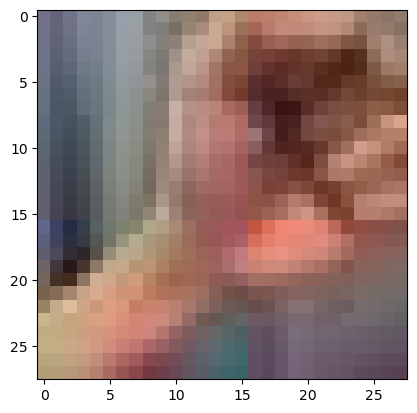

In [60]:
predicted_result = model.predict(x_test_norm)
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

## 더 좋은 네트워크 만들어보기

In [59]:
# 성능 올리기: 하이퍼파라미터 조정하기

import tensorflow as tf
from tensorflow import keras

conv_channel_1 = 32
conv_channel_2 = 64
fc_dense = 64
scissor_rock_paper_train_epoch = 20

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(conv_channel_1, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(conv_channel_2, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(fc_dense, activation='relu'))
# model.add(keras.layers.Dropout(0.5)) #드롭아웃test_accuracy: 0.8333333134651184
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

# datagen = keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False
# )
#학습률 스케줄링 설정 
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
#                                                           decay_steps=10000,
#                                                           decay_rate=0.9)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# model.compile(optimizer=optimizer,
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
#WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. 
# Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.

# optimizer = tf.keras.optimizers.legacy.Adam()  # 레거시 Adam 옵티마이저 사용
# model.compile(optimizer=optimizer,
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])



# # 모델 컴파일
# model.compile(optimizer=optimizer,
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])
#WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, 
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
#WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.SGD`.
#WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. 
# Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.SGD`.

#레거시 Adam 옵티마이저 사용
optimizer = tf.keras.optimizers.legacy.Adam()

# 레거시 SGD 옵티마이저 사용
# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)

# 모델 컴파일
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=scissor_rock_paper_train_epoch)


# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm ,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print("테스트 정확도: {:.4f}".format(test_accuracy))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 64)               

# 소감
---
<ol>
<li>Model Test Accuracy 높이기 : 데이터 확보가 관건이었다.

    - LMS의 가이드대로 가위바위보 각각 100장, 총 300장의 데이터셋으로 모델학습을 하고 나서 Validation 과 Test accuracy 의 너무 큰 차이로 다소 당황스러웠다. 이후 구루분들의 데이터셋 각각 500장, 총 1500장의 데이터셋에 더하여 http://www.laurencemoroney.com/rock-paper-scissors-dataset/ Laurence Moroney의 rock-paper-scissors-dataset과 더하여 총 7692의 학습 데이터셋을 마련하고 이중 20%을 validation으로 분할하여 본격적인 모델학습을 하였고 마침내 최종 Test Accuracy 98% 에 이르렀다. 
    - 일요일 이른 아침부터 이 시각 월요일 새벽 1시, 총 15시간의 긴 시간동안 수없는 시행착오를 거치며 얻은 결론은 결국 Data! 수집과 전처리, 운용과 관리가 얼마나 중요한지 뼈아프게 실감하는 하루였다. 
    - 딥러닝과의 떨리는 첫 Date는 한 글자 바꾼 Data 이 단어로 마무리지어야겠다.

</li>
<li> 다양한 접근과 방법들을 발견하다 : rock-paper-scissors model

     부족한 데이터셋도 문제였지만 Model Test를 내가 잘하고 있나? 하는 의구심이 차츰 들기 시작했다. 그래서 github에서 rock-paper-scissors model을 뒤져보는데 정말 다양한 방식과 접근을 구경할 수 있었다. VGG 로 접근한 분도 계셨고 tensorflow.js로 브라우저로 모델을 선보이는 분도 계셨다. 시간되면 꼭 한번 시도해 보려 한다. https://github.com/search?q=rock-paper-scissors+model&type=repositories&s=stars&o=desc
</li>
<li>마침내 내 노트북에서 DL모델학습을 시켜 보다.

    - 금요일 정규시간에는 colab에서 작업을 했었는데 데이터셋 용량이 많아지다 보니 업로드하는게 힘들어져 이렇게 된 이상, 노트북에서 작업하기로 했다. 그래서 토요일 하루를 셋팅하는데 바쳤다. 아나콘다의 입에 필요한 라이브러리 프레임워크를 마구마구 넣고 vscode까지 셋팅하니 일요일이었다. 그러나 Apple M2 Max(12코어 CPU, 38코어 GPU, 16코어 Neural Engine)96GB 통합 메모리의 퍼포먼스를 만끽해보는 시간들이었다.
    - 보안상 인터넷을 쓸 수 없는 공간에 들어가 노트북만으로 작업을 해야 한다는 가정하에 꼭 아니 반드시 한번은 했어야 할 노트북 셋팅작업이었다. 그래서 토요일 하루가 아깝지 않았다. 

</li>

</ol>
